In [1]:
# import lib
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

In [2]:
# custom Dropout Layer
class MyDropout(layers.Layer):
    def __init__(self, rate):
        super().__init__()
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            mask = tf.cast(tf.random.uniform(tf.shape(inputs)) > self.rate, inputs.dtype)
            return mask * inputs / (1.0 - self.rate)  # scale to preserve expectation
        return inputs

In [3]:
# custom Regularizer
class MyRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, l1=1e-5, l2=1e-4):
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x):
        l1_term = self.l1 * tf.reduce_sum(tf.abs(x))
        l2_term = self.l2 * tf.reduce_sum(tf.square(x))
        return l1_term + l2_term

    def get_config(self):
        return {'l1': self.l1, 'l2': self.l2}

In [4]:
# load and preprocess dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# build model using custom components
def create_model():
    model = tf.keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=MyRegularizer()),
        MyDropout(0.4),
        layers.Dense(256, activation='relu', kernel_regularizer=MyRegularizer()),
        MyDropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()

# train the model
history = model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=128, verbose=1)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7163 - loss: 1.0622 - val_accuracy: 0.8405 - val_loss: 0.6542
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8357 - loss: 0.6605 - val_accuracy: 0.8595 - val_loss: 0.5830
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8469 - loss: 0.6099 - val_accuracy: 0.8612 - val_loss: 0.5612
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8567 - loss: 0.5675 - val_accuracy: 0.8659 - val_loss: 0.5275
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8601 - loss: 0.5412 - val_accuracy: 0.8737 - val_loss: 0.5039
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8665 - loss: 0.5198 - val_accuracy: 0.8701 - val_loss: 0.4939
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8674 - loss: 0.5075 - val_accuracy: 0.8599 - val_loss: 0.5155
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8684 - loss: 0.4899 - val_accuracy: 0.

In [6]:
# evaluate on test data
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy with Custom Dropout & L1+L2: {accuracy:.4f}")

Test Accuracy with Custom Dropout & L1+L2: 0.8724


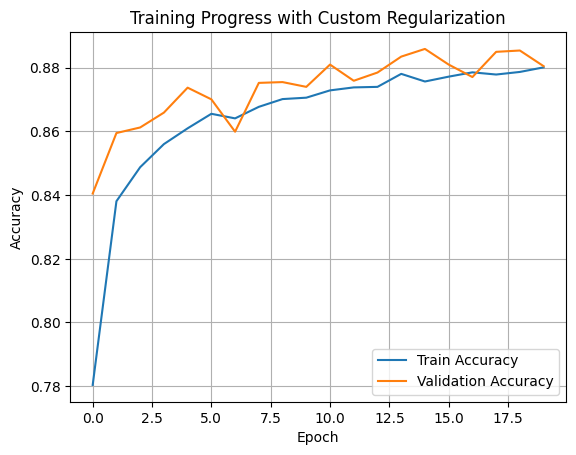

In [7]:
# plot training/validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training Progress with Custom Regularization")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()